In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
%matplotlib inline


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def zscore(series):
    return (series - series.mean())/np.std(series)

In [36]:
data = pd.read_csv('broadcasting.csv')

In [37]:
data = data[-63:].iloc[: , 1:] 

In [38]:
def find_cointegrated_pairs(data):
    n = len(data.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
 
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data.iloc[:, i]
            S2 = data.iloc[:, j]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((data.iloc[:, i].name, data.iloc[:, j].name)) 
    return pairs

In [39]:
find_cointegrated_pairs(data)

[]

In [27]:
symbols = list(data.columns)
data_returns = pd.DataFrame()
for sym in symbols:
    data_returns[sym] = (data[sym]/data[sym].shift(1) - 1)*100

In [28]:
def find_correlated_pairs(data, corr):
    n = len(data.columns)
    corr_matrix = np.zeros((n,n))

    pairs_corr = []
    for i in range(n):
        for j in range(i+1, n):
            MLP1 = data.iloc[:, i]
            MLP2 = data.iloc[:, j]
            correl = MLP1.corr(MLP2)
            corr_matrix[i, j] = correl
            if correl > corr:
                pairs_corr.append((data.iloc[:, i].name, data.iloc[:, j].name))
    return pairs_corr  

In [29]:
find_correlated_pairs(data_returns, 0.90)

[('LILA', 'LILAK'), ('LBTYA', 'LBTYK'), ('DISCA', 'DISCK'), ('LBRDK', 'LBRDA')]

In [30]:
def find_pairs(data, data_returns, corr):
    n = len(data.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    corr_matrix = np.zeros((n,n))
 
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data.iloc[:, i]
            S2 = data.iloc[:, j]
            S1_r = data_returns.iloc[:, i]
            S2_r = data_returns.iloc[:, j]
            
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            correl = S1_r.corr(S2_r)
            
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            corr_matrix[i, j] = correl
            
            if pvalue < 0.05 and correl > corr:
                pairs.append((data.iloc[:, i].name, data.iloc[:, j].name)) 
    return pairs

In [35]:
 find_pairs(data, data_returns, 0.250)

[('ATUS', 'WOW')]

In [16]:
S1 = data['ETP']
S2 = data['NS']

In [17]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.0095222048371044407

In [18]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ETP']
beta = results.params[1]
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NS   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     45.89
Date:                Mon, 07 May 2018   Prob (F-statistic):           5.66e-09
Time:                        15:41:25   Log-Likelihood:                -132.93
No. Observations:                  63   AIC:                             269.9
Df Residuals:                      61   BIC:                             274.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8195      4.861     -2.226      0.030     -20.539      -1.100
ETP            1.8555      0.274      6.774      0.000       1.308       2.403
==============================================================================
Omnibus:                       45.006   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.095
Skew:                           2.178   Prob(JB):                     5.13e-32
Kurtosis:                       8.994   Cond. No.                         339.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

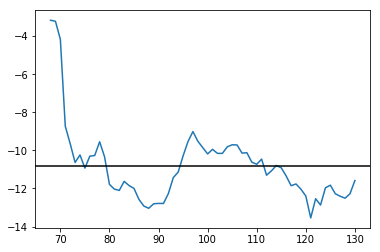

In [20]:
spread = S2 - beta * S1
spread.plot()
plt.axhline(spread.mean(), color = 'black')

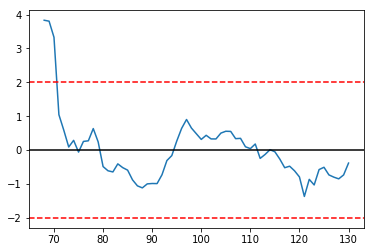

In [21]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color = 'black')
plt.axhline(-2, color = 'red', linestyle = '--')
plt.axhline(2, color = 'red', linestyle = '--');

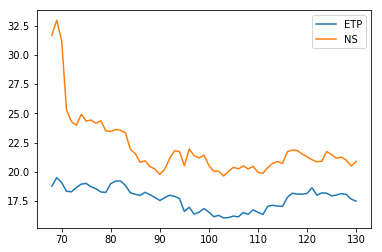

In [22]:
pd.concat([S1, S2], axis = 1).plot();

In [48]:
adfuller(spread, 1)

(-1.9596639256548121,
 0.30453414247012944,
 0,
 62,
 {'1%': -3.5405226788291762,
  '10%': -2.5923136524453696,
  '5%': -2.9094272025108254},
 -97.306348167730675)